## Background

New York is a big city and gives a lot of opportunities for different kinds of businesses, but learning of the existing market is one of key inputs to plan a successful one. Here I will be building the solution which will help a potential investor or business owner to make the judgment about finding a good spot stop for opening a new place in the city.
More specifically here we will analyze already existing places in New York City and will make a suggestion on the placement of a new Bakery in Manhattan.  
Once having suggested areas, they will be presented on the map for better comprehension.

## Data Description

Following data points are used in this case:
1) The list of New York neighborhoods with respective geographical coordinates.  
2) Foursquare’s venues listings with information about places’ coordinates and categories. This will allow to identify the relation of places to neighborhoods and analyze the profile of each neighborhood in terms of what places are typically located there.  
3) Foursquare’s categories dictionary which defines the tree-structure of all available place categories on Foursquare. This will allow to apply some grouping over places list to have comparable categories over different neighborhoods.   
4) Geopy to find the NY geographical location for map drawing. 

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


<a id='item1'></a>


## Download and Explore Dataset


#### Download Neihborhoods list with corresponding coordinates.

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


Next, let's load the data.


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Review the loaded data.


In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [5]:
neighborhoods_data = newyork_data['features']

Tranform the data into a _pandas_ dataframe


In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Populate the dataframe.


In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Find NYC coordinates with help of Geopy


In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('NYC coordinates are {}, {}.'.format(latitude, longitude))

NYC coordinates are 40.7127281, -74.0060152.


In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### For this study we'll focus on the Manhattan borough specifically.


In [11]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [12]:
## Get the geographical coordinates of Manhattan.

address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


Let's now visualize Manhattan's neighborhoods.


In [13]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Now we need to fetch the venues data from Foursquare.


## Explore Neighborhoods in Manhattan


#### Define Foursquare Parameters and load Venues information

In [14]:
CLIENT_ID = 'SBPPJXXVK3DNXUMMAEXGNQ5DRZDY5DAPBQB5RS3VDEVBIYAD'
CLIENT_SECRET = 'VD4P01B1EGYSIV3W5ICNTCRO1XQAABP0G1X4FZ0BNXDXKODO'
VERSION = '20180605'
LIMIT = 100
radius = 300


In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

<a id='item2'></a>


#### Build some functions that will help to ingest Foursquare data


In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        response = requests.get(url).json()
        
        try:
            results = response["response"]['groups'][0]['items']
        except:
            pring(str(response))
            pass
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
# type your answer here
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude'],
                                   radius=700
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [20]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

# make the GET request
categories_response = requests.get(categories_url).json()['response']


In [21]:
def get_category_hierarchy(cat_name, categories):
    for c in categories:
        if c['name'] == cat_name:
            return [c]
        nested = get_category_hierarchy(cat_name, c['categories'])
        if nested:
            nested.insert(0, c)
            return nested
    
    return None
            
    

In [22]:
# Now we are ready to clean the json and structure it into a pandas dataframe.

print(len(manhattan_venues['Venue Category'].unique()))

for i in range(0,manhattan_venues.shape[0]):
    orig_cat = manhattan_venues.loc[i, 'Venue Category']
    try:
        new_cat = get_category_hierarchy(orig_cat, categories_response['categories'])[1]['name']
        manhattan_venues.loc[i, 'Venue Category'] = new_cat
    except:
        print('Failed to find new group for: ' + orig_cat)
        

print(len(manhattan_venues['Venue Category'].unique()))
manhattan_venues.head(20)

329
Failed to find new group for: Shop & Service
Failed to find new group for: Outdoors & Recreation
205


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Athletics & Sports
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Sam's Pizza,40.879435,-73.905859,Pizza Place
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
5,Marble Hill,40.876551,-73.91066,Estrellita Poblana V,40.879687,-73.906257,Mexican Restaurant
6,Marble Hill,40.876551,-73.91066,El Malecon,40.879338,-73.904457,Caribbean Restaurant
7,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
8,Marble Hill,40.876551,-73.91066,Baker Athletic Complex,40.872061,-73.914876,Athletics & Sports
9,Marble Hill,40.876551,-73.91066,ALDI,40.877836,-73.904656,Food & Drink Shop


#### Let's check the size of the resulting dataframe


In [23]:
print(manhattan_venues.shape)
#manhattan_venues.head()

len(manhattan_venues['Venue Category'].unique())

# create map
# map_venues = folium.Map(location=[40.876844, -73.906204], zoom_start=11)

# for lat, lon in zip(manhattan_venues['Venue Latitude'], manhattan_venues['Venue Longitude']):
#     folium.CircleMarker(
#         [lat, lon],
#         radius=3,
#         fill=True,
#         fill_opacity=0.7).add_to(map_venues)
       
# map_venues




(3755, 7)


205

Let's check how many venues were returned for each neighborhood


In [24]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,100,100,100,100,100,100
Carnegie Hill,100,100,100,100,100,100
Central Harlem,69,69,69,69,69,69
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,87,87,87,87,87,87
East Village,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues


In [25]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 205 uniques categories.


<AxesSubplot:xlabel='Neighborhood _'>

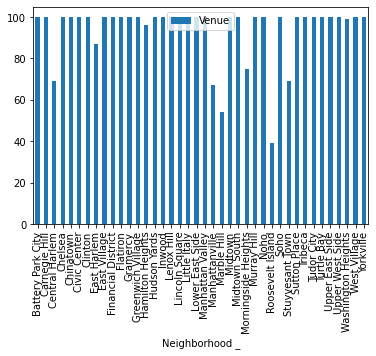

In [50]:
# let's plot the bar chart on numbers of places

counts = manhattan_venues.groupby('Neighborhood').count().copy()
counts['Neighborhood _'] = counts.index
#counts.head()
counts.plot.bar(x='Neighborhood _', y='Venue')

<a id='item3'></a>


## Build features


In [26]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head(20)

,Neighborhood,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Child Care Service,Chocolate Shop,Christmas Market,Circus,Clothing Store,Club House,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Czech Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Falafel Restaurant,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Government Building,Greek Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Hill,Historic Site,Hot Dog Joint,Hotel,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Latin American Restaurant,Laundry Service,Library,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Newsstand,Nightclub,Non-Profit,Office,Optical Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Public Art,Record Shop,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Rest Area,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Stadium,State / Provincial Park,Steakhouse,Supplement Shop,Swiss Restaurant,Tailor Shop,Tea Room,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Waterfront
0,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,

And let's examine the new dataframe size.


In [27]:
manhattan_onehot.shape

(3755, 206)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [28]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bike Rental / Bike Share,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Bus Station,Bus Stop,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Child Care Service,Chocolate Shop,Christmas Market,Circus,Clothing Store,Club House,Coffee Shop,College Academic Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Czech Restaurant,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Falafel Restaurant,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Government Building,Greek Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Heliport,Hill,Historic Site,Hot Dog Joint,Hotel,Indian Restaurant,Intersection,Irish Pub,Italian Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Latin American Restaurant,Laundry Service,Library,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,Newsstand,Nightclub,Non-Profit,Office,Optical Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Public Art,Record Shop,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Rest Area,Restaurant,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shop & Service,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Spiritual Center,Sporting Goods Shop,Stadium,State / Provincial Park,Steakhouse,Supplement Shop,Swiss Restaurant,Tailor Shop,Tea Room,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Waterfront
0,Battery Park City,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.020000,0.110000,0.01,0.00,0.00,0.010000,0.000000,0.010000,0.000000,0.030000,0.00,0.000000,0.010000,0.00,0.000000,0.010000,0.000000,0.00,0.00,0.00,0.01,0.00,0.030000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.060000,0.00,0.080000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.010000,0.010000,0.00,0.00,0.000000,0.010000,0.020000,0.000000,0.000000,0.010000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.01,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.060000,0.02,0.000000,0.000000,0.010000,0.000000,0.00,0.00,0.010000,0.00,0.000000,0.000000,0.00,0.00,0.01,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.050000,0.000000,0.000000,0.00,0.010000,0.02,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.03,0.000000,0.030000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.01,0.010000,0.00,

#### Let's confirm the new size


In [29]:
manhattan_grouped.shape

(40, 206)

## Build the model and predict the demand

In [30]:
target_venue_type = 'Bakery' 

# find other most influencing venues
corr_matrix = manhattan_grouped.corr().abs()
corr_matrix = corr_matrix.sort_values(target_venue_type, ascending=False)

y_indexes = corr_matrix.index.values.tolist()[1:16]
# indexes.insert(0, 'Neighborhood')

# manhattan_grouped_cleaned = manhattan_grouped[indexes]
# manhattan_grouped_cleaned.head(30)

x = manhattan_grouped[y_indexes]
y = manhattan_grouped[[target_venue_type]]

linear_regression = LinearRegression()
linear_regression.fit(x,y)
y_pred = linear_regression.predict(x)

# y_pred
manhattan_scored = manhattan_grouped[['Neighborhood', target_venue_type]]
manhattan_scored['DemandProjected'] = y_pred
manhattan_scored['DemandAdjusted'] = manhattan_scored['DemandProjected'] - manhattan_scored[target_venue_type]
adj_mean = manhattan_scored['DemandAdjusted'].mean()
adj_std = manhattan_scored['DemandAdjusted'].std()
manhattan_scored['DemandAdjustedStd'] = (manhattan_scored['DemandAdjusted'] - adj_mean) / adj_std

manhattan_scored.head(10)
#manhattan_scored['DemandAdjusted'].mean()
#manhattan_scored['DemandAdjusted'].std()

<ipython-input-30-6254ac5c524f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manhattan_scored['DemandProjected'] = y_pred
<ipython-input-30-6254ac5c524f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manhattan_scored['DemandAdjusted'] = manhattan_scored['DemandProjected'] - manhattan_scored[target_venue_type]
<ipython-input-30-6254ac5c524f>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

,Neighborhood,Bakery,DemandProjected,DemandAdjusted,DemandAdjustedStd
0,Battery Park City,0.010000,0.020845,1.084461e-02,1.322483e+00
1,Carnegie Hill,0.050000,0.044883,-5.117240e-03,-6.240393e-01
2,Central Harlem,0.000000,0.009774,9.774096e-03,1.191936e+00
3,Chelsea,0.050000,0.022984,-2.701588e-02,-3.294543e+00
4,Chinatown,0.100000,0.100000,5.551115e-17,6.695455e-15
5,Civic Center,0.010000,0.017463,7.462615e-03,9.100541e-01
6,Clinton,0.030000,0.023104,-6.896363e-03,-8.410006e-01
7,East Harlem,0.068966,0.068966,0.000000e+00,-7.404137e-17
8,East Village,0.010000,0.018280,8.280179e-03,1.009755e+00
9,Financial District,0.000000,0.008896,8.895548e-03,1.084798e+00


<AxesSubplot:>

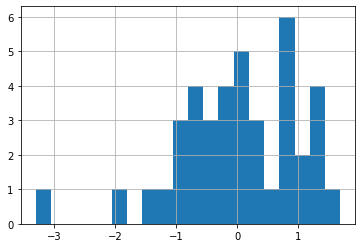

In [51]:
# Let's see the distribution of DemandAdjustedStd
manhattan_scored['DemandAdjustedStd'].hist(bins=20)

In [32]:
# let's see at ones that are at least 1 standard deviation high 

In [33]:
manhattan_scored_high_demand = manhattan_scored[manhattan_scored['DemandAdjustedStd'] >= 1]
manhattan_scored_high_demand

,Neighborhood,Bakery,DemandProjected,DemandAdjusted,DemandAdjustedStd
0,Battery Park City,0.01,0.020845,0.010845,1.322483
2,Central Harlem,0.00,0.009774,0.009774,1.191936
8,East Village,0.01,0.018280,0.008280,1.009755
9,Financial District,0.00,0.008896,0.008896,1.084798
10,Flatiron,0.01,0.020430,0.010430,1.271871
14,Hudson Yards,0.00,0.010617,0.010617,1.294708
19,Lower East Side,0.02,0.033813,0.013813,1.684446


In [34]:
# df1.merge(df2, left_on='lkey', right_on='rkey'

suggestions = manhattan_scored_high_demand.merge(neighborhoods, left_on='Neighborhood', right_on='Neighborhood')
suggestions

,Neighborhood,Bakery,DemandProjected,DemandAdjusted,DemandAdjustedStd,Borough,Latitude,Longitude
0,Battery Park City,0.01,0.020845,0.010845,1.322483,Manhattan,40.711932,-74.016869
1,Central Harlem,0.00,0.009774,0.009774,1.191936,Manhattan,40.815976,-73.943211
2,East Village,0.01,0.018280,0.008280,1.009755,Manhattan,40.727847,-73.982226
3,Financial District,0.00,0.008896,0.008896,1.084798,Manhattan,40.707107,-74.010665
4,Flatiron,0.01,0.020430,0.010430,1.271871,Manhattan,40.739673,-73.990947
5,Hudson Yards,0.00,0.010617,0.010617,1.294708,Manhattan,40.756658,-74.000111
6,Lower East Side,0.02,0.033813,0.013813,1.684446,Manhattan,40.717807,-73.980890


## Display results

In [35]:
# create map of Manhattan using latitude and longitude values
latitude = suggestions.loc[0, 'Latitude']
longitude = suggestions.loc[0, 'Longitude']
map_suggestions = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(suggestions['Latitude'], suggestions['Longitude'], suggestions['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_suggestions)  
    
map_suggestions

<a id='item4'></a>


<a id='item5'></a>
